# Exoplanet Classification with TensorFlow
SMOTE to address class imbalance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical

## Class

In [ ]:
class DeepLearningClassifier:
    """
    A deep learning-based classifier for handling imbalanced datasets using SMOTE and CNN architecture.

    Attributes:
        train_path (str): Path to the training dataset.
        test_path (str): Path to the testing dataset.
        model (Sequential): The deep learning model.
        history (History): Training history of the model.
        class_weights (dict): Weights for handling class imbalance.
    """

    def __init__(self, train_path, test_path):
        """
        Initializes the DeepLearningClassifier with training and testing data paths.

        Args:
            train_path (str): Path to the training dataset.
            test_path (str): Path to the testing dataset.
        """
        self.train_path = train_path
        self.test_path = test_path
        self.model = None

    def load_data(self):
        """
        Loads the training and testing datasets from the specified paths.

        Returns:
            None
        """
        self.train_data = pd.read_csv(self.train_path)
        self.test_data = pd.read_csv(self.test_path)

    def preprocess_data(self):
        """
        Preprocesses the data by splitting into features and labels, applying SMOTE for oversampling,
        and standardizing the features.

        Returns:
            None
        """
        # Separate features and labels
        X_train = self.train_data.iloc[:, 1:]
        y_train = self.train_data.iloc[:, 0]
        X_test = self.test_data.iloc[:, 1:]
        y_test = self.test_data.iloc[:, 0]

        # Standardize the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Apply SMOTE for oversampling the minority class
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Convert labels to categorical
        y_train = to_categorical(y_train - 1)  # Assuming labels start at 1
        y_test = to_categorical(y_test - 1)

        # Reshape for CNN input
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42
        )
        self.X_test = X_test
        self.y_test = y_test

    def build_model(self, input_shape):
        """
        Builds a convolutional neural network (CNN) model.

        Args:
            input_shape (tuple): Shape of the input features.

        Returns:
            None
        """
        model = Sequential([
            Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            Conv1D(64, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')  # Assuming 2 classes
        ])

        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        self.model = model

    def train_model(self, epochs=20, batch_size=32):
        """
        Trains the CNN model using the training data.

        Args:
            epochs (int, optional): Number of epochs. Defaults to 20.
            batch_size (int, optional): Batch size. Defaults to 32.

        Returns:
            None
        """
        self.history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_val, self.y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    def evaluate_model(self):
        """
        Evaluates the trained CNN model on the test dataset.

        Returns:
            float: Accuracy of the model on the test dataset.
        """
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        return accuracy

    def show_classification_report(self):
        """
        Displays the classification report and confusion matrix for the test dataset.

        Returns:
            None
        """
        y_pred = self.model.predict(self.X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_actual_classes = np.argmax(self.y_test, axis=1)

        # Classification report
        print("Classification Report:")
        print(classification_report(y_actual_classes, y_pred_classes))

        # Confusion matrix
        cm = confusion_matrix(y_actual_classes, y_pred_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_actual_classes))
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    def plot_accuracy(self):
        """
        Plots the training and validation accuracy over epochs.

        Returns:
            None
        """
        # Plot training and validation accuracy
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.show()

## Main

In [ ]:
path_to_train = 'exoTrain.csv'
path_to_test = 'exoTest.csv'
classifier = DeepLearningClassifier(path_to_train, path_to_test)
classifier.load_data()
classifier.preprocess_data()
classifier.build_model(input_shape=(3197, 1))  # Shape for CNN input
classifier.train_model(epochs=10, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.5765 - loss: 0.6860 - val_accuracy: 0.7748 - val_loss: 0.4864
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.7834 - loss: 0.4537 - val_accuracy: 0.9208 - val_loss: 0.3325
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8937 - loss: 0.2754 - val_accuracy: 0.9673 - val_loss: 0.1488
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9243 - loss: 0.2004 - val_accuracy: 0.9842 - val_loss: 0.0803
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9495 - loss: 0.1834 - val_accuracy: 0.9901 - val_loss: 0.0537
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9672 - loss: 0.1012 - val_accuracy: 0.9866 - val_loss: 0.0634
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9731 - loss: 0.1465 - val_accuracy: 0.9950 - val_loss: 0.0390
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9761 - loss: 0.0710 - val_ac

Test Accuracy: 98.25%


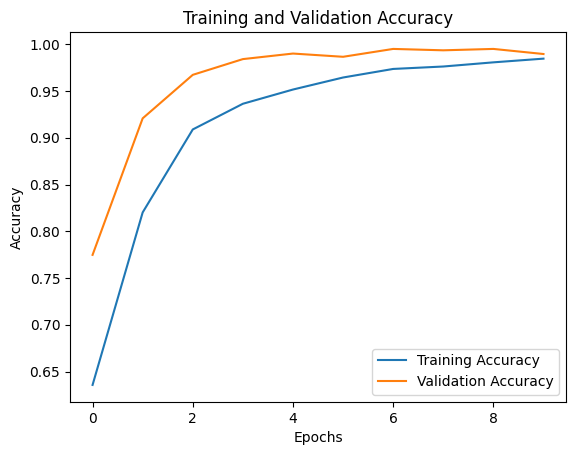

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       565
           1       0.22      0.40      0.29         5

    accuracy                           0.98       570
   macro avg       0.61      0.69      0.64       570
weighted avg       0.99      0.98      0.98       570



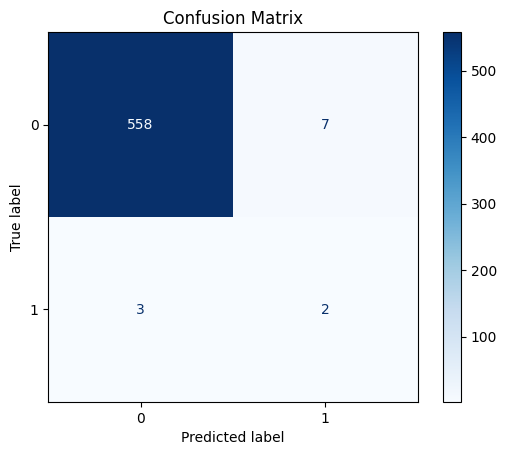

In [ ]:
classifier.evaluate_model()
classifier.plot_accuracy()
classifier.show_classification_report()

# Combine Train and Test dataset

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load CSV files
exo_train = pd.read_csv("exoTrain.csv")
exo_test = pd.read_csv("exoTest.csv")

# Merge both datasets
exoplanets = pd.concat([exo_train, exo_test], ignore_index=True)

# Save merged dataset
exoplanets.to_csv("exoplanets.csv", index=False)
print("Merged dataset saved as exoplanets.csv.")

# Separate features and target
X = exoplanets.iloc[:, 1:]
y = exoplanets.iloc[:, 0]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Convert back to DataFrame
balanced_exoplanets = pd.DataFrame(X_resampled, columns=exoplanets.columns[1:])
balanced_exoplanets.insert(0, exoplanets.columns[0], y_resampled)  # Reinsert target column

# Save the balanced dataset
balanced_exoplanets.to_csv("exoplanets_balanced.csv", index=False)
print("Balanced dataset saved as exoplanets_balanced.csv.")

Merged dataset saved as exoplanets.csv.
Balanced dataset saved as exoplanets_balanced.csv.


# TensorFlow with Combined Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

## Class

In [ ]:
class DeepLearningClassifier:
    """
    A deep learning-based classifier for handling imbalanced datasets using SMOTE and CNN architecture.

    Attributes:
        data_path (str): Path to the combined dataset (train + test).
        model (Sequential): The deep learning model.
        history (History): Training history of the model.
        class_weights (dict): Weights for handling class imbalance.
    """

    def __init__(self, data_path):
        """
        Initializes the DeepLearningClassifier with data path.

        Args:
            data_path (str): Path to the combined dataset.
        """
        self.data_path = data_path
        self.model = None

    def load_data(self):
        """
        Loads the combined dataset from the specified path.

        Returns:
            None
        """
        self.data = pd.read_csv(self.data_path)

    def preprocess_data(self):
        """
        Preprocesses the data by splitting into features and labels, applying SMOTE for oversampling,
        and standardizing the features.

        Returns:
            None
        """
        # Separate features and labels
        X = self.data.iloc[:, 1:].values  # Features
        y = self.data.iloc[:, 0].values   # Labels

        # Standardize the features
        #scaler = StandardScaler()
        #X = scaler.fit_transform(X)

        # Apply SMOTE for oversampling the minority class
        #smote = SMOTE(random_state=42)
        #X, y = smote.fit_resample(X, y)

        # Convert labels to binary (0 and 1)
        y = y - 1

        # Reshape for CNN input
        X = X.reshape(X.shape[0], X.shape[1], 1)

        # Split data into train and validation sets (80-20 split)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

    def build_model(self, input_shape):
        """
        Builds a convolutional neural network (CNN) model.

        Args:
            input_shape (tuple): Shape of the input features.

        Returns:
            None
        """
        model = Sequential([
            Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            Conv1D(64, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Dropout(0.3),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')  # Binary classification output
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',  # Use binary cross-entropy for binary classification
            metrics=['accuracy']
        )
        self.model = model

    def train_model(self, epochs=20, batch_size=32):
        """
        Trains the CNN model using the training data.

        Args:
            epochs (int, optional): Number of epochs. Defaults to 20.
            batch_size (int, optional): Batch size. Defaults to 32.

        Returns:
            None
        """
        self.history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_val, self.y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    def evaluate_model(self):
        """
        Evaluates the trained CNN model on the test dataset.

        Returns:
            float: Accuracy of the model on the test dataset.
        """
        y_pred = self.model.predict(self.X_val) > 0.5
        accuracy = np.mean(y_pred == self.y_val)
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")
        return accuracy

    def show_classification_report(self):
        """
        Displays the classification report and confusion matrix for the validation dataset.

        Returns:
            None
        """
        y_pred = self.model.predict(self.X_val)
        y_pred_classes = (y_pred > 0.5).astype("int32")
        y_actual_classes = self.y_val

        # Classification report
        print("Classification Report:")
        print(classification_report(y_actual_classes, y_pred_classes))

        # Confusion matrix
        cm = confusion_matrix(y_actual_classes, y_pred_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_actual_classes))
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    def plot_accuracy(self):
        """
        Plots the training and validation accuracy over epochs.

        Returns:
            None
        """
        # Plot training and validation accuracy
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.show()

## Main

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequentia

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.6025 - loss: 0.6606 - val_accuracy: 0.9105 - val_loss: 0.4265
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8191 - loss: 0.4151 - val_accuracy: 0.9412 - val_loss: 0.2259
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8960 - loss: 0.2651 - val_accuracy: 0.9724 - val_loss: 0.1534
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9425 - loss: 0.1743 - val_accuracy: 0.9902 - val_loss: 0.0791
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9586 - loss: 0.1233 - val_accuracy: 0.9929 - val_loss: 0.0472
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9739 - loss: 0.0856 - val_accuracy: 0.9920 - val_loss: 0.0345
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9670 - loss: 0.0947 - val_accuracy: 0.9898 - val_loss: 0.0386
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9813 - loss: 0.0530 - v

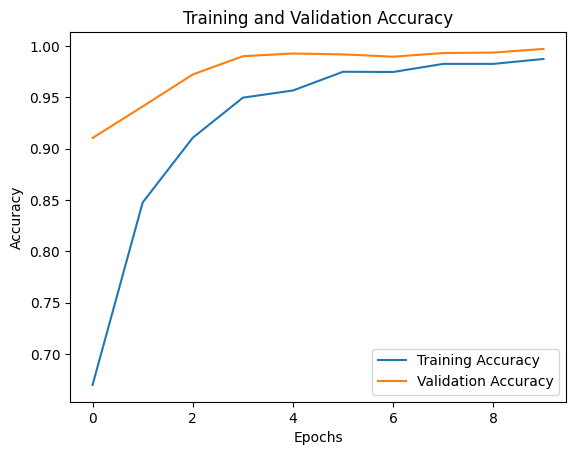

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1142
           1       0.99      1.00      1.00      1104

    accuracy                           1.00      2246
   macro avg       1.00      1.00      1.00      2246
weighted avg       1.00      1.00      1.00      2246



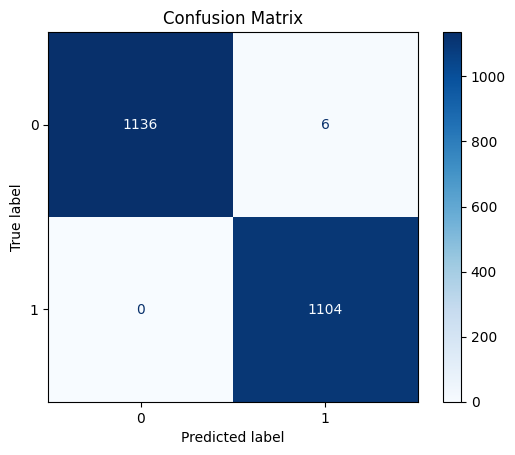

In [ ]:
classifier = DeepLearningClassifier(data_path='exoplanets_balanced.csv')
classifier.load_data()
classifier.preprocess_data()
classifier.build_model(input_shape=(classifier.X_train.shape[1], 1))
classifier.train_model(epochs=10, batch_size=32)
classifier.evaluate_model()
classifier.plot_accuracy()
classifier.show_classification_report()